In [1]:
import torch
import datasets, networks, sampling, completion, evaluation
import matplotlib.pyplot as plt
from torch import nn

In [2]:
#HYPERPARAMETERS
num_epochs = 10

# TODO Select a optimizer. [ 'adam', 'adamw', 'rmsprop' ]
optimizer_option = 'adam'

# TODO Select a batch size.
batch_size = 64

# TODO Select a learning rate.
lr = 0.01


num_residual = 15
num_kernels = 128

In [3]:
ds = datasets.Dataset('mnist', batch_size=batch_size)
training_data = ds.get_train_data_loader()
test_data = ds.get_test_data_loader()

Using device: cuda:0
Epoch:   1/ 10, Batch     1, Loss: 5.7062
Epoch:   1/ 10, Batch   101, Loss: 1.2520
Epoch:   1/ 10, Batch   201, Loss: 1.0804
Epoch:   1/ 10, Batch   301, Loss: 1.0388
Epoch:   1/ 10, Batch   401, Loss: 1.0019
Epoch:   1/ 10, Batch   501, Loss: 0.9804
Epoch:   1/ 10, Batch   601, Loss: 0.9479
Epoch:   1/ 10, Batch   701, Loss: 0.9208
Epoch:   1/ 10, Batch   801, Loss: 0.9019
Epoch:   1/ 10, Batch   901, Loss: 0.8788
-----------------------------------------
Epoch:   1 took 181.05s
Epoch:   1, Test Loss: 0.8715
-----------------------------------------


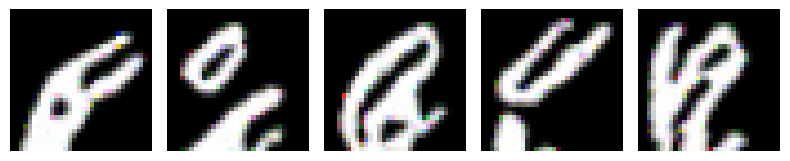

Epoch:   2/ 10, Batch     1, Loss: 0.8922
Epoch:   2/ 10, Batch   101, Loss: 0.8542
Epoch:   2/ 10, Batch   201, Loss: 0.8431
Epoch:   2/ 10, Batch   301, Loss: 0.8328
Epoch:   2/ 10, Batch   401, Loss: 0.8269
Epoch:   2/ 10, Batch   501, Loss: 0.8096
Epoch:   2/ 10, Batch   601, Loss: 0.8076
Epoch:   2/ 10, Batch   701, Loss: 0.8091
Epoch:   2/ 10, Batch   801, Loss: 0.7923
Epoch:   2/ 10, Batch   901, Loss: 0.7822
-----------------------------------------
Epoch:   2 took 178.39s
Epoch:   2, Test Loss: 0.7842
-----------------------------------------


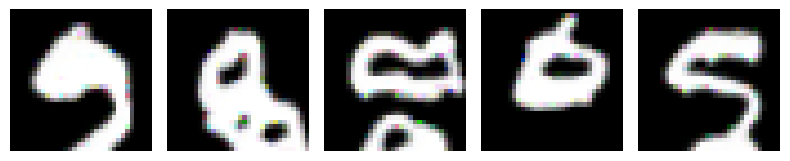

Epoch:   3/ 10, Batch     1, Loss: 0.7611
Epoch:   3/ 10, Batch   101, Loss: 0.7747
Epoch:   3/ 10, Batch   201, Loss: 0.7712
Epoch:   3/ 10, Batch   301, Loss: 0.7749
Epoch:   3/ 10, Batch   401, Loss: 0.7600
Epoch:   3/ 10, Batch   501, Loss: 0.7692
Epoch:   3/ 10, Batch   601, Loss: 0.7481
Epoch:   3/ 10, Batch   701, Loss: 0.7561
Epoch:   3/ 10, Batch   801, Loss: 0.7443
Epoch:   3/ 10, Batch   901, Loss: 0.7500
-----------------------------------------
Epoch:   3 took 177.53s
Epoch:   3, Test Loss: 0.8420
-----------------------------------------


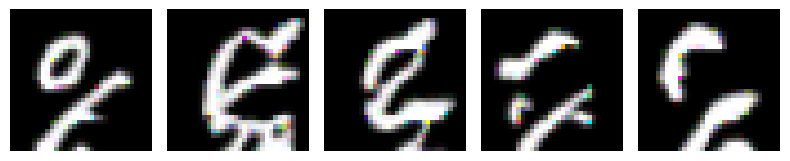

Epoch:   4/ 10, Batch     1, Loss: 0.7159
Epoch:   4/ 10, Batch   101, Loss: 0.7449
Epoch:   4/ 10, Batch   201, Loss: 0.7356
Epoch:   4/ 10, Batch   301, Loss: 0.7323
Epoch:   4/ 10, Batch   401, Loss: 0.7277
Epoch:   4/ 10, Batch   501, Loss: 0.7279
Epoch:   4/ 10, Batch   601, Loss: 0.7261
Epoch:   4/ 10, Batch   701, Loss: 0.7210
Epoch:   4/ 10, Batch   801, Loss: 0.7243
Epoch:   4/ 10, Batch   901, Loss: 0.7270
-----------------------------------------
Epoch:   4 took 177.28s
Epoch:   4, Test Loss: 0.7561
-----------------------------------------


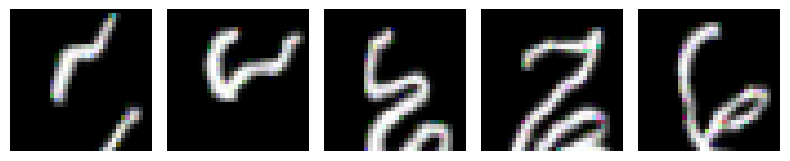

Epoch:   5/ 10, Batch     1, Loss: 0.7112
Epoch:   5/ 10, Batch   101, Loss: 0.7213
Epoch:   5/ 10, Batch   201, Loss: 0.7146
Epoch:   5/ 10, Batch   301, Loss: 0.7129
Epoch:   5/ 10, Batch   401, Loss: 0.7177
Epoch:   5/ 10, Batch   501, Loss: 0.7191
Epoch:   5/ 10, Batch   601, Loss: 0.7026
Epoch:   5/ 10, Batch   701, Loss: 0.7040
Epoch:   5/ 10, Batch   801, Loss: 0.7097
Epoch:   5/ 10, Batch   901, Loss: 0.7079
-----------------------------------------
Epoch:   5 took 178.27s
Epoch:   5, Test Loss: 1.1507
-----------------------------------------


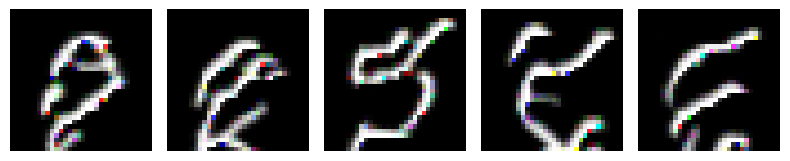

Epoch:   6/ 10, Batch     1, Loss: 0.7367
Epoch:   6/ 10, Batch   101, Loss: 0.7073
Epoch:   6/ 10, Batch   201, Loss: 0.7019
Epoch:   6/ 10, Batch   301, Loss: 0.7083
Epoch:   6/ 10, Batch   401, Loss: 0.6970
Epoch:   6/ 10, Batch   501, Loss: 0.6938
Epoch:   6/ 10, Batch   601, Loss: 0.6933
Epoch:   6/ 10, Batch   701, Loss: 0.6925
Epoch:   6/ 10, Batch   801, Loss: 0.7016
Epoch:   6/ 10, Batch   901, Loss: 0.6976
-----------------------------------------
Epoch:   6 took 177.85s
Epoch:   6, Test Loss: 0.7003
-----------------------------------------


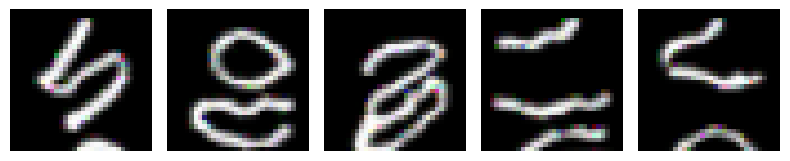

Epoch:   7/ 10, Batch     1, Loss: 0.7211
Epoch:   7/ 10, Batch   101, Loss: 0.6890
Epoch:   7/ 10, Batch   201, Loss: 0.6891
Epoch:   7/ 10, Batch   301, Loss: 0.6849
Epoch:   7/ 10, Batch   401, Loss: 0.6919
Epoch:   7/ 10, Batch   501, Loss: 0.6911
Epoch:   7/ 10, Batch   601, Loss: 0.6858
Epoch:   7/ 10, Batch   701, Loss: 0.6862
Epoch:   7/ 10, Batch   801, Loss: 0.6829
Epoch:   7/ 10, Batch   901, Loss: 0.6748
-----------------------------------------
Epoch:   7 took 177.26s
Epoch:   7, Test Loss: 0.6738
-----------------------------------------


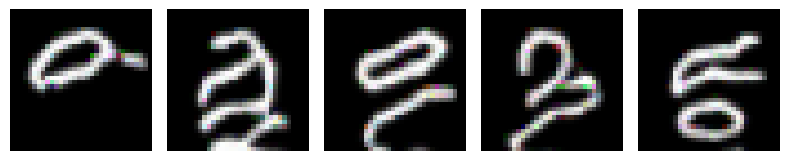

Epoch:   8/ 10, Batch     1, Loss: 0.6725
Epoch:   8/ 10, Batch   101, Loss: 0.6811
Epoch:   8/ 10, Batch   201, Loss: 0.6764
Epoch:   8/ 10, Batch   301, Loss: 0.6759
Epoch:   8/ 10, Batch   401, Loss: 0.6859
Epoch:   8/ 10, Batch   501, Loss: 0.6773
Epoch:   8/ 10, Batch   601, Loss: 0.6796
Epoch:   8/ 10, Batch   701, Loss: 0.6705
Epoch:   8/ 10, Batch   801, Loss: 0.6769
Epoch:   8/ 10, Batch   901, Loss: 0.6713
-----------------------------------------
Epoch:   8 took 185.20s
Epoch:   8, Test Loss: 0.6737
-----------------------------------------


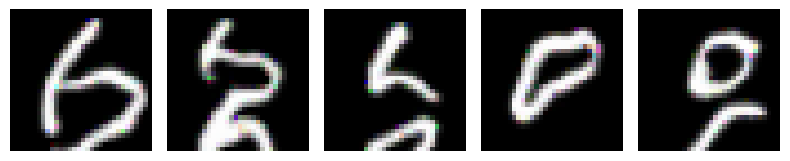

Epoch:   9/ 10, Batch     1, Loss: 0.6645
Epoch:   9/ 10, Batch   101, Loss: 0.6662
Epoch:   9/ 10, Batch   201, Loss: 0.6671
Epoch:   9/ 10, Batch   301, Loss: 0.6700
Epoch:   9/ 10, Batch   401, Loss: 0.6729
Epoch:   9/ 10, Batch   501, Loss: 0.6721
Epoch:   9/ 10, Batch   601, Loss: 0.6663
Epoch:   9/ 10, Batch   701, Loss: 0.6737
Epoch:   9/ 10, Batch   801, Loss: 0.6696
Epoch:   9/ 10, Batch   901, Loss: 0.6740
-----------------------------------------
Epoch:   9 took 185.26s
Epoch:   9, Test Loss: 0.6660
-----------------------------------------


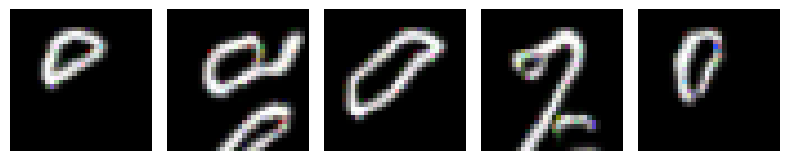

Epoch:  10/ 10, Batch     1, Loss: 0.6832
Epoch:  10/ 10, Batch   101, Loss: 0.6642
Epoch:  10/ 10, Batch   201, Loss: 0.6669
Epoch:  10/ 10, Batch   301, Loss: 0.6676
Epoch:  10/ 10, Batch   401, Loss: 0.6631
Epoch:  10/ 10, Batch   501, Loss: 0.6622
Epoch:  10/ 10, Batch   601, Loss: 0.6621
Epoch:  10/ 10, Batch   701, Loss: 0.6575
Epoch:  10/ 10, Batch   801, Loss: 0.6638
Epoch:  10/ 10, Batch   901, Loss: 0.6650
-----------------------------------------
Epoch:  10 took 182.68s
Epoch:  10, Test Loss: 0.6607
-----------------------------------------


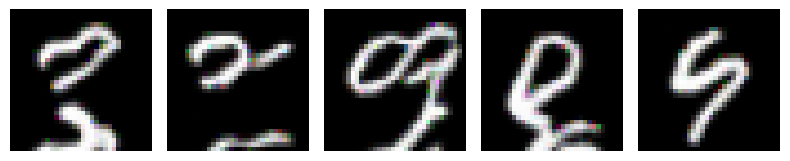

Training took 2107.93s


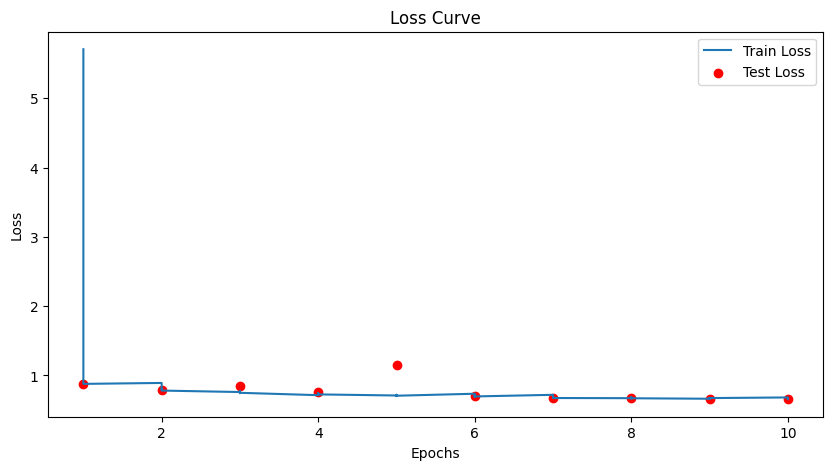

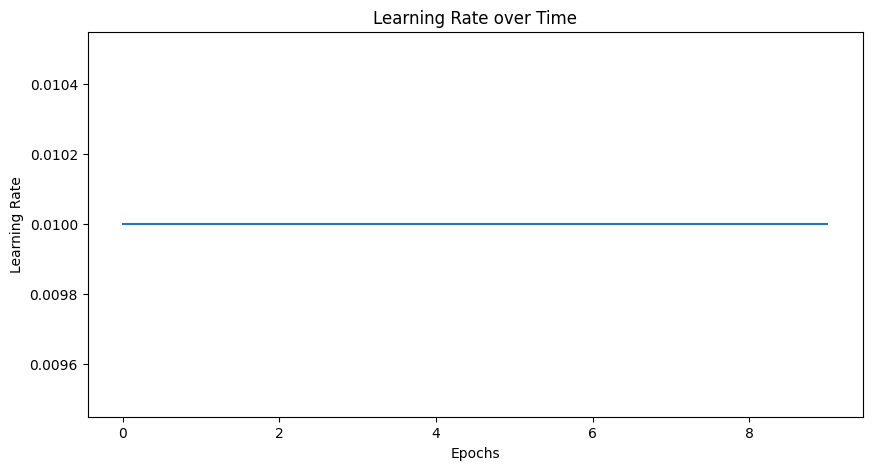

In [4]:
# Training
import time
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torch.optim import Adam, AdamW, RMSprop, SGD 

PixelCNN = networks.PixelCNN(num_kernels=num_kernels, num_residual=num_residual)
device = torch.device('cuda:0')
print(f'Using device: {device}')
print('=========================================')

PixelCNN.to(device)

learning_rates = []
train_loss_curve = []
test_loss_curve = []
train_loss_epochs = []
test_loss_epochs = []
optimizer = None

# Select optimizer
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(PixelCNN.parameters(), lr)
  
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(PixelCNN.parameters(), lr)
  
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(PixelCNN.parameters(), lr)
  
else:
  optimizer = torch.optim.SGD(PixelCNN.parameters(), lr, momentum=0.9)  


overall_start_time = time.time()

# training loop
for epoch in range(num_epochs):

  epoch_start_time = time.time()
  # Switch to training mode.
  PixelCNN.train()

  losses = []
  batch_idx = 0

  for images, labels in training_data:

    images = images.to(device)
    output = PixelCNN(images)
    images = images.view(-1)
    output = torch.reshape(output, (batch_size, 256, 3, 32, 32))
    output = output.permute(0,2,3,4,1).contiguous().view(-1, 256)
    images = images*255
    loss = nn.functional.cross_entropy(output, images.long())
    loss.backward()
    torch.nn.utils.clip_grad_norm_(PixelCNN.parameters(), 1)
    optimizer.step()
    for param_group in optimizer.param_groups:
      learning_rates.append(param_group['lr'])
    optimizer.zero_grad()


    losses.append(loss.detach().clone())

    if batch_idx % 100 == 0:
      average_loss = torch.stack(losses).mean().item()
      train_loss_curve.append(average_loss)
      train_loss_epochs.append(epoch + 1)
      losses = []
      print(f'Epoch: {epoch + 1:3d}/{num_epochs:3d}, Batch {batch_idx + 1:5d}, Loss: {average_loss:.4f}')
    batch_idx += 1

  epoch_end_time = time.time()
  print('-----------------------------------------')
  print(f'Epoch: {epoch + 1:3d} took {epoch_end_time - epoch_start_time:.2f}s')
  test_loss = evaluation.evaluate(model=PixelCNN, test_data_loader=test_data, device=device, batch_size=batch_size)
  test_loss_curve.append(test_loss)
  test_loss_epochs.append(epoch + 1)
  print(f'Epoch: {epoch + 1:3d}, Test Loss: {test_loss:.4f}')
  print('-----------------------------------------')
  

  samples = sampling.sample(PixelCNN, num_samples=5)
  sampling.save_samples(samples, filename="MNIST", mnist=True)
  

overall_end_time = time.time()
print('=========================================')
print(f'Training took {overall_end_time - overall_start_time:.2f}s')

# Loss Curve Plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epochs, train_loss_curve, label='Train Loss')
plt.scatter(test_loss_epochs, test_loss_curve, color='red', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Learning Rate Plot
num_batches = len(training_data)
learning_rates_res = [sum(learning_rates[i * num_batches:(i + 1) * num_batches]) / num_batches for i in range(num_epochs)]
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates_res)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Time')
plt.show()

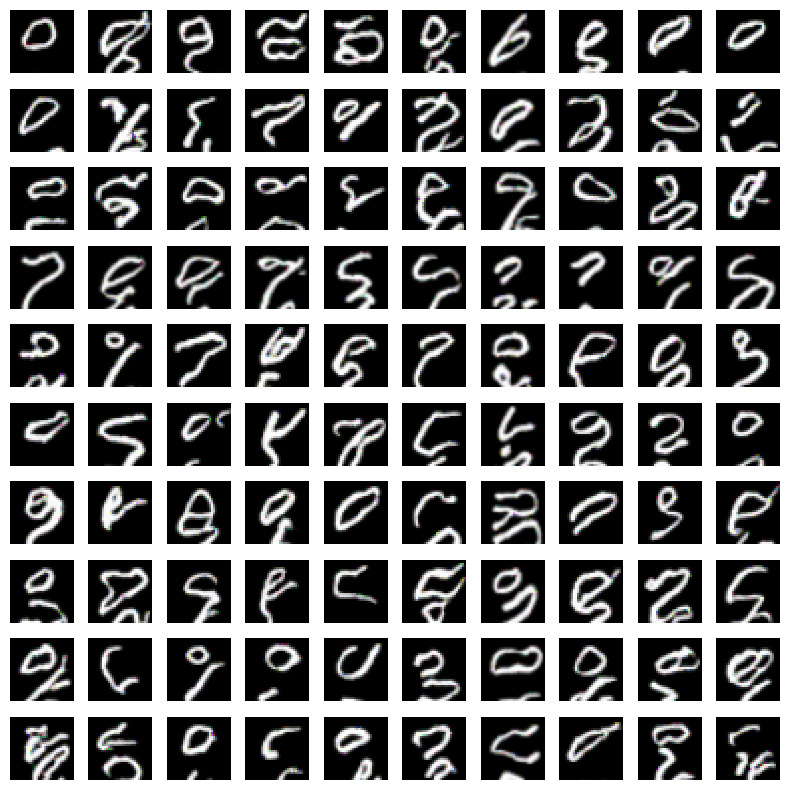

In [5]:
final_samples= sampling.sample(PixelCNN, num_samples=100)
sampling.save_samples(final_samples, filename = "MNIST", mnist = True)

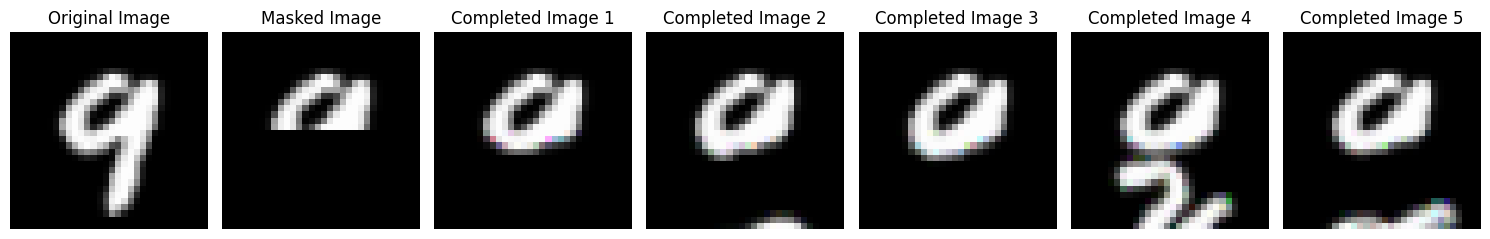

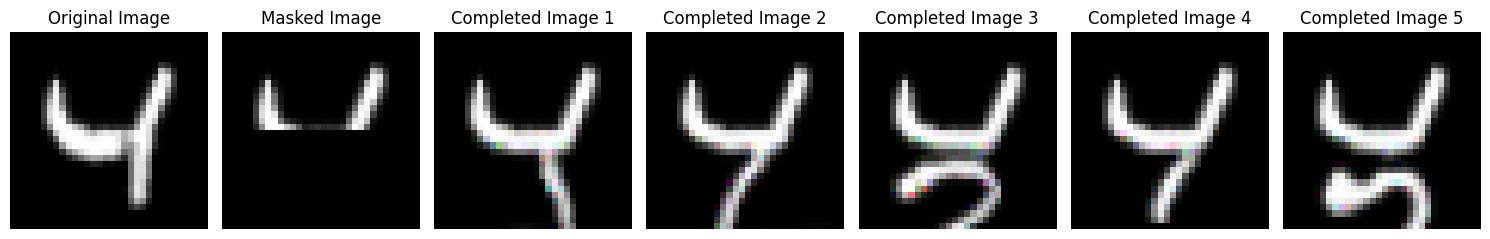

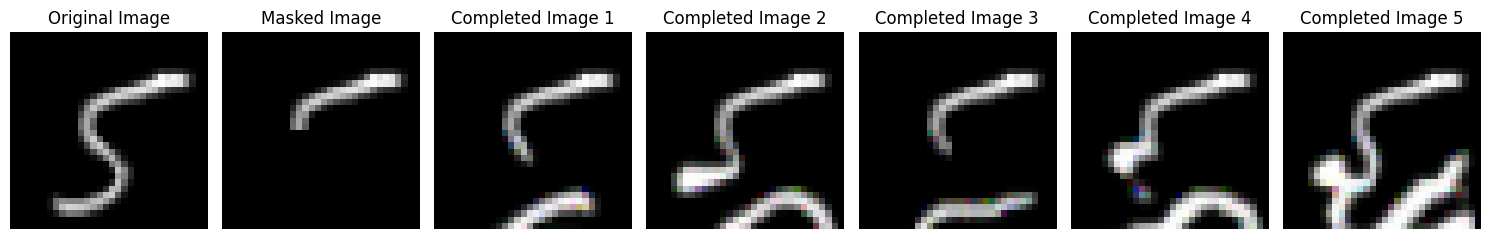

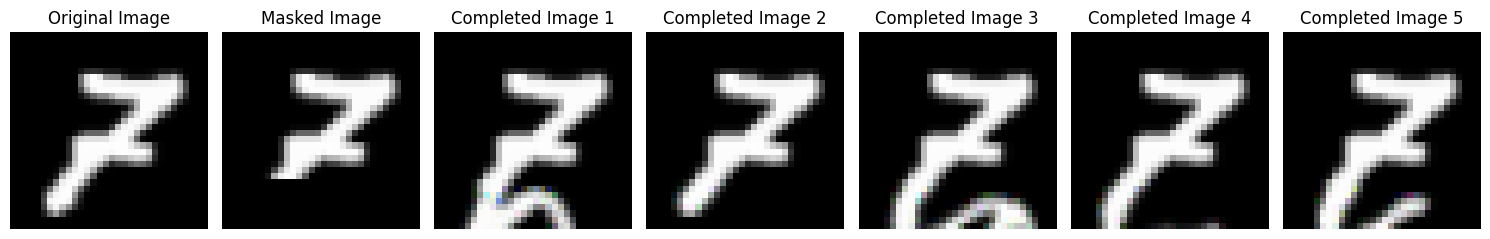

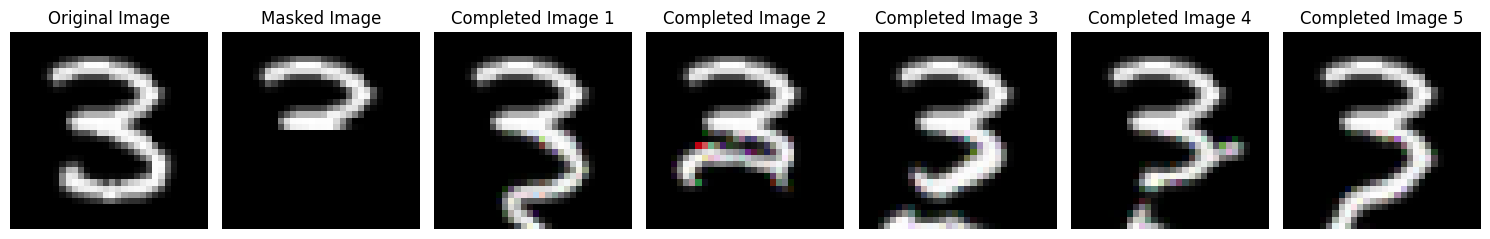

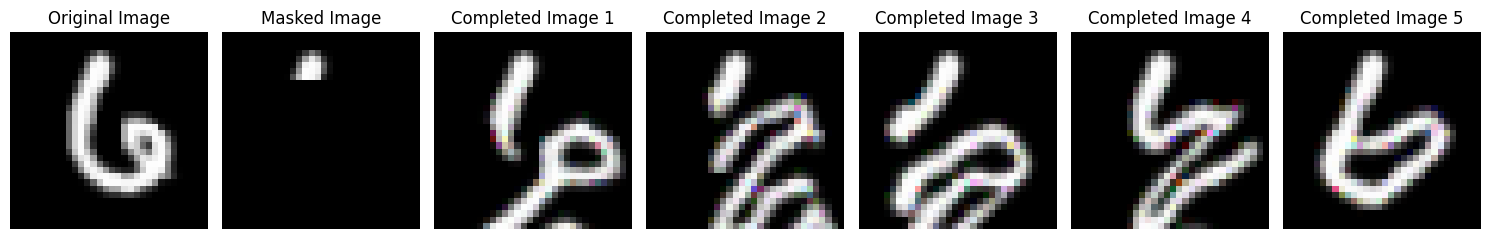

In [6]:
for i in range(3):
    original_img = completion.get_random_image(ds)
    masked_img, mask = completion.mask_image(original_img)
    completed_img = completion.complete(PixelCNN, masked_img, mask)
    completion.plot_completed_images(original_img, masked_img, completed_img)

for i in range(3):
    original_img = completion.get_random_image(ds)
    masked_img, mask = completion.mask_image(original_img, mask_fraction=0.25*(i+1))
    completed_img = completion.complete(PixelCNN, masked_img, mask)
    completion.plot_completed_images(original_img, masked_img, completed_img)